In [1]:
from langchain_community.document_loaders.csv_loader import CSVLoader
import pandas as pd
import re
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda
from langchain_experimental.tools.python.tool import PythonAstREPLTool
from markitdown import MarkItDown
import dotenv
import os

dotenv.load_dotenv()

True

### 2-1. 프롬프트로 분석하기

In [117]:
df = pd.read_csv("./data/titanic.csv")

In [118]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [120]:
md = MarkItDown()

In [121]:
convert_df = md.convert("./data/titanic.csv")

In [122]:
convert_df = convert_df.text_content

In [123]:
prompt = PromptTemplate.from_template(
    """
    table : {convert}

    당신은 데이터 분석 전문가입니다.
    주어진 table 데이터를 기반으로 데이터 분석에 도움을 주세요.

    query : {query}

    """
    )

In [2]:
llm = ChatOpenAI(model="gpt-4o-mini",
                 temperature=0.,)

In [125]:
chain = prompt | llm

In [126]:
query = "이 데이터에서 2번째 행의 이름은 무엇인가요?"

In [127]:
result = chain.invoke({"convert":convert_df,
                       "query" : query
                       })

In [128]:
result.content

'주어진 데이터에서 2번째 행의 이름은 "Cumings, Mrs. John Bradley (Florence Briggs Thayer)"입니다.'

In [129]:
def chat_llm(query):
    result = chain.invoke({"convert":convert_df,
                       "query" : query
                       })    
    
    return result.content

In [130]:
answer = chat_llm("이 데이터에서 얻을 수 있는 인사이트는 무엇인가요?")

In [131]:
print(answer)

주어진 데이터는 타이타닉 호의 승객 정보를 포함하고 있으며, 이를 통해 여러 가지 인사이트를 도출할 수 있습니다. 다음은 이 데이터에서 얻을 수 있는 몇 가지 주요 인사이트입니다:

1. **생존율 분석**:
   - 전체 승객 중 생존한 비율과 사망한 비율을 계산하여 생존율을 분석할 수 있습니다. 성별, 나이, 선실 등급(Pclass)별로 생존율을 비교하면 특정 그룹이 더 높은 생존율을 보였는지 확인할 수 있습니다.

2. **성별에 따른 생존율**:
   - 남성과 여성의 생존율을 비교하여 성별이 생존에 미친 영향을 분석할 수 있습니다. 일반적으로 여성의 생존율이 남성보다 높았던 것으로 알려져 있습니다.

3. **연령대별 생존율**:
   - 연령대별로 생존율을 분석하여 어린이, 청소년, 성인, 노인 등 각 연령대의 생존율을 비교할 수 있습니다. 예를 들어, 어린이의 생존율이 높았는지 확인할 수 있습니다.

4. **선실 등급(Pclass)과 생존율**:
   - 선실 등급에 따른 생존율을 분석하여 고급 선실(Pclass 1) 승객이 더 높은 생존율을 보였는지 확인할 수 있습니다. 이는 사회적 지위가 생존에 미친 영향을 나타낼 수 있습니다.

5. **가족 구성원 수와 생존율**:
   - SibSp(형제/자매 수)와 Parch(부모/자녀 수) 변수를 사용하여 가족과 함께 탑승한 승객의 생존율을 분석할 수 있습니다. 가족과 함께 탑승한 경우 생존율이 높았는지 확인할 수 있습니다.

6. **요금(Fare)과 생존율**:
   - 승객의 요금과 생존율 간의 상관관계를 분석하여 요금이 생존에 미친 영향을 평가할 수 있습니다. 높은 요금을 지불한 승객이 더 높은 생존율을 보였는지 확인할 수 있습니다.

7. **탑승 항구(Embarked)와 생존율**:
   - 승객이 탑승한 항구에 따라 생존율을 분석하여 특정 항구에서 탑승한 승객이 더 높은 생존율을 보였는지 확인할 수 있습니다.

8. **결측치 분석**:
   - Age, Cabin, Embarked와 같

In [132]:
answer = chat_llm("이 데이터를 이용한 분석 순서를 추천해주세요. 무엇부터 해야하나요?")

In [133]:
print(answer)

데이터 분석을 시작하기 위해서는 다음과 같은 단계로 진행하는 것이 좋습니다. 이 단계들은 데이터의 이해, 전처리, 탐색적 데이터 분석(EDA), 모델링, 그리고 결과 해석 및 시각화를 포함합니다.

### 1. 데이터 이해
- **데이터 구조 파악**: 데이터의 각 열(특성)의 의미를 이해합니다. 예를 들어, `PassengerId`, `Survived`, `Pclass`, `Name`, `Sex`, `Age`, `SibSp`, `Parch`, `Ticket`, `Fare`, `Cabin`, `Embarked` 등의 열이 무엇을 의미하는지 확인합니다.
- **데이터 타입 확인**: 각 열의 데이터 타입(정수, 실수, 문자열 등)을 확인합니다.

### 2. 데이터 전처리
- **결측치 처리**: `Age`, `Cabin`, `Fare` 등에서 결측치가 있는지 확인하고, 이를 처리하는 방법(삭제, 평균/중앙값 대체 등)을 결정합니다.
- **데이터 형식 변환**: 필요에 따라 데이터 형식을 변환합니다. 예를 들어, `Survived`는 이진 변수로 변환할 수 있습니다.
- **범주형 변수 인코딩**: `Sex`, `Embarked`와 같은 범주형 변수를 수치형으로 변환합니다(예: 원-핫 인코딩).

### 3. 탐색적 데이터 분석 (EDA)
- **기초 통계량 확인**: 각 열의 기초 통계량(평균, 중앙값, 최솟값, 최댓값 등)을 확인합니다.
- **데이터 시각화**: 
  - 생존자와 비생존자의 분포를 시각화합니다.
  - 나이, 성별, 클래스(Pclass)별 생존율을 시각화합니다.
  - 요금(Fare) 분포를 확인하고, 생존 여부에 따른 요금의 차이를 시각화합니다.
- **상관관계 분석**: 생존 여부와 다른 변수들 간의 상관관계를 분석합니다.

### 4. 모델링
- **모델 선택**: 생존 예측을 위한 모델을 선택합니다. 예를 들어, 로지스틱 회귀, 결정 트리, 랜덤 포레스트, SVM 등을 고려할 수 있습니다.
- **모델 학습**: 데이터를 훈련 세트

### 2-1. 도구 사용

In [50]:
df2 = pd.read_csv("./data/athlete_events.csv")

In [51]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int64  
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  object 
 3   Age     261642 non-null  float64
 4   Height  210945 non-null  float64
 5   Weight  208241 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271116 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  int64  
 10  Season  271116 non-null  object 
 11  City    271116 non-null  object 
 12  Sport   271116 non-null  object 
 13  Event   271116 non-null  object 
 14  Medal   39783 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 31.0+ MB


In [52]:
df2.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [53]:
prompt = ChatPromptTemplate([
    ("system", """당신은 pandas 라이브러리를 사용할 수 있는 전문가입니다. 주어진 df의 형태를 참고하여 코드를 작성합니다. \
                다음은 `print(df.head())`의 형태입니다. {head}
     
                ### 예시1
                ```python
     
                len(df)
                ```
                ### 예시2
                ```python
     
                # sum_gamerounds에 대한 히스토그램
                plt.figure(figsize=(12, 6))
                sns.histplot(df['sum_gamerounds'], bins=10, kde=True)
                plt.title('Distribution of Sum Gamerounds')
                plt.xlabel('Sum Gamerounds')
                plt.ylabel('Frequency')
                plt.grid()
                plt.show()
                ```
     
     """),
    ("human", "{query}")
])

In [54]:
code_tool = PythonAstREPLTool(name="python_repl_ast", 
                              description="A Python shell. Use this to execute python commands. \
                                           Input should be a valid python command. When using this tool, \
                                           sometimes output is abbreviated - make sure it does not look abbreviated before using it in your answer.",
                               locals={"df":df2})

In [55]:
def extract_code(content):

    content = content.content

    return re.findall(r'```python\n(.*?)\n```', content, re.DOTALL)[0]

In [ ]:
def checker(response):

    code = extract_code(response)

    code_prompt = PromptTemplate.from_template("""
            너는 주어진 차트를 해석해주는 데이터분석가야.
            주어진 차트를 해석해줘
            예시를 줄테니 비슷한 느낌으로 답변해주면 돼.
                                               
            ### 예시 1
            - UserID는 고유한 식별값입니다.
            
            ### 예시 2
            - X축은 2013-02-11 ~ 2016-04-16까지의 시간을 나타내는 TimeStamp 컬럼입니다.
            - Y축은 Passengers로 해당 날짜에 탑승한 승객을 나타냅니다.
            - 해당 차트는 ROI를 모니터링하기 위한 선 차트로 보여집니다.
            - 제목은 'Number of passengers on board by date'로 일자 별로 탑승한 승객을 보려는 시계열 차트입니다.

            code : {code}                                          

            """
            )
    
    code_chain = code_prompt | llm

    code_tool.run(code)
    response = code_chain.invoke({"code":code})
    print(response.content)
    return response    

In [57]:
chain = prompt | llm | RunnableLambda(checker)

<string>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



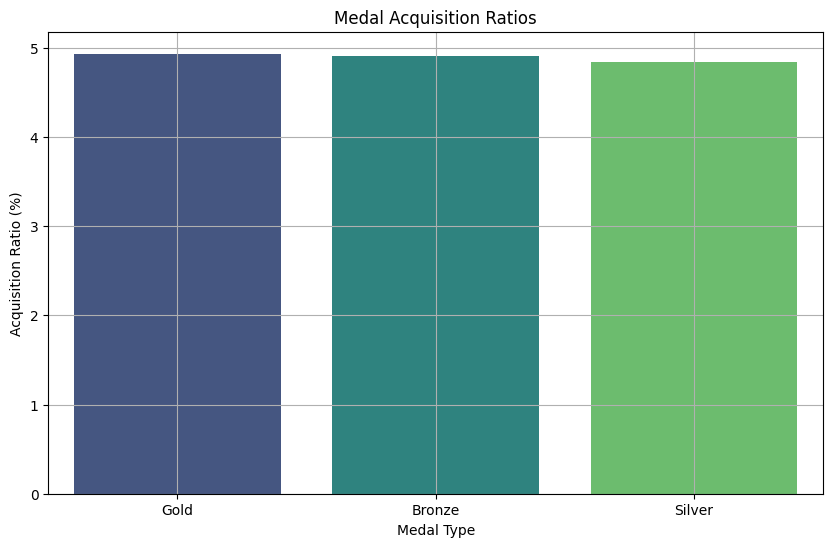

Medal
Gold      4.932206
Bronze    4.903805
Silver    4.837782
Name: count, dtype: float64
### 해석
- X축은 메달의 종류를 나타내며, 'Gold', 'Silver', 'Bronze'와 같은 메달 유형이 포함됩니다.
- Y축은 각 메달 유형에 대한 획득 비율을 퍼센트(%)로 나타냅니다.
- 해당 차트는 메달 획득 비율을 시각화하기 위한 막대 차트입니다.
- 제목은 'Medal Acquisition Ratios'로, 각 메달 유형에 대한 획득 비율을 비교하고자 하는 목적을 가지고 있습니다.
- 차트는 참가자 수에 대한 메달 획득 비율을 보여주며, 이를 통해 어떤 메달이 상대적으로 더 많이 획득되었는지를 한눈에 파악할 수 있습니다.


In [58]:
result = chain.invoke({"head": df2.head(),
                       "query":"메달 별 획득 비율은 어때?"})

In [59]:
result.content

"### 해석\n- X축은 메달의 종류를 나타내며, 'Gold', 'Silver', 'Bronze'와 같은 메달 유형이 포함됩니다.\n- Y축은 각 메달 유형에 대한 획득 비율을 퍼센트(%)로 나타냅니다.\n- 해당 차트는 메달 획득 비율을 시각화하기 위한 막대 차트입니다.\n- 제목은 'Medal Acquisition Ratios'로, 각 메달 유형에 대한 획득 비율을 비교하고자 하는 목적을 가지고 있습니다.\n- 차트는 참가자 수에 대한 메달 획득 비율을 보여주며, 이를 통해 어떤 메달이 상대적으로 더 많이 획득되었는지를 한눈에 파악할 수 있습니다."

In [60]:
answer = llm.invoke(f""" memory : {result.content} 
                왜 비율이 100%가 아닌거야?
                """)

In [61]:
print(answer.content)

메달 획득 비율이 100%가 아닌 이유는 여러 가지가 있을 수 있습니다. 일반적으로 메달 획득 비율은 특정 집단이나 참가자 수에 대한 메달의 비율을 나타내기 때문에, 다음과 같은 이유로 100%에 도달하지 않을 수 있습니다:

1. **참가자 수**: 차트에서 보여주는 메달 획득 비율은 전체 참가자 수에 대한 메달 수의 비율일 수 있습니다. 예를 들어, 전체 참가자가 100명이고, 그 중 30명이 메달을 획득했다면, 메달을 획득한 비율은 30%가 됩니다. 이 경우, 메달을 획득하지 않은 참가자도 존재하기 때문에 비율이 100%가 아닙니다.

2. **메달 종류**: 메달의 종류가 'Gold', 'Silver', 'Bronze'로 나뉘어 있기 때문에, 각 메달 유형의 비율은 전체 메달 수에 대한 비율로 계산됩니다. 예를 들어, 금메달을 10개, 은메달을 5개, 동메달을 15개 획득했다면, 총 메달 수는 30개가 되고, 각 메달의 비율은 전체 메달 수에 대한 비율로 계산됩니다. 이 경우에도 각 메달의 비율이 100%가 되지 않습니다.

3. **비율 계산 방식**: 비율이 어떻게 계산되었는지에 따라 다를 수 있습니다. 예를 들어, 특정 메달 유형에 대한 비율이 전체 메달 수가 아닌 특정 기준(예: 특정 종목의 참가자 수)에 대한 비율로 계산되었을 수 있습니다.

결론적으로, 메달 획득 비율이 100%가 아닌 것은 메달을 획득하지 않은 참가자가 존재하거나, 메달의 종류에 따라 비율이 계산되기 때문입니다.
